# Transmission Line Analytics & Machine Learning
This notebook demonstrates the analysis of transmission lines, including impedance and VSWR calculations, matching techniques (single-stub and quarter-wave transformer), and machine learning workflows for regression and classification of transmission line behavior.

- **Section 1:** Parameter setup and basic calculations
- **Section 2:** Visualization of standing waves and VSWR
- **Section 3:** Matching techniques (stub, quarter-wave)
- **Section 4:** Machine learning regression and classification for transmission line data
- **Section 5:** Model saving and output
 
Github: https://github.com/Arpit-Raj1/EMT-Assignment02

In [20]:
%load_ext autoreload
%autoreload 2

import os, math, json, pathlib
import numpy as np
import matplotlib.pyplot as plt

# Ensure src is importable
import sys
repo_root = pathlib.Path('..').resolve()
if str(repo_root) not in sys.path:
    sys.path.append(str(repo_root))

from src.tl_basics import gamma_Z0
from src.tl_abcd import abcd_of_tline, abcd_of_shunt_admittance, z_in_from_abcd
from src.tl_metrics import gamma_of_impedance, vswr_from_gamma
from src.tl_matching import single_stub_shunt, quarter_wave_transform


# Training utilities (expected in your project)
try:
    from src.tl_train import make_regression_data, make_classification_data
except Exception as e:
    print("Note: src.tl_train.make_* not found; ML sections will synthesize data")

# Create output folders if needed
os.makedirs('figures', exist_ok=True)
os.makedirs('models', exist_ok=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
# Host line parameters (per-unit-length):  R [Ω/m], L [H/m], G [S/m], C [F/m]
R, L, G, C = 0.05, 3e-7, 1e-8, 8e-11       # weakly lossy line
f0 = 1.0e9                                 # design frequency (Hz)
l_total = 0.25                             # physical line length (m)
ZL = 25 + 0j                               # load (Ω), start with a purely real

w0 = 2*np.pi*f0
gamma, Z0 = gamma_Z0(R, L, G, C, f0)
beta = np.imag(gamma)

print("Computed Z0 (may be complex for lossy lines):", Z0)
Gamma = gamma_of_impedance(ZL, Z0)
vswr0 = vswr_from_gamma(Gamma)
print("VSWR (unmatched):", vswr0)

Computed Z0 (may be complex for lossy lines): (61.23724357497348-0.000811575029754295j)
VSWR (unmatched): 2.4494897435152163


## Transmission Line Setup
This section defines the per-unit-length parameters for the transmission line, the design frequency, total line length, and the load impedance. These parameters are used throughout the analysis and matching computations.
- **R, L, G, C**: Resistance, inductance, conductance, and capacitance per unit length.
- **f0**: Design frequency (Hz) for analysis.
- **l_total**: Total physical length of the transmission line (meters).
- **ZL**: Load impedance (Ohms), can be complex for generality.
The code computes the characteristic impedance and VSWR for the unmatched line.

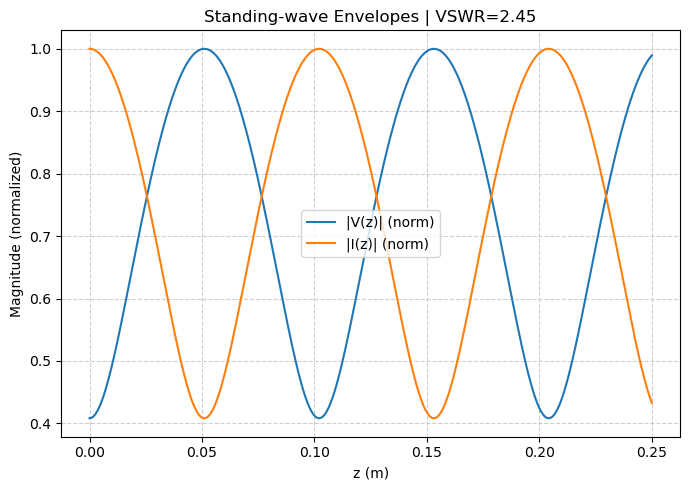

In [22]:
# Compute forward/backward waves along the line relative to load reference
N = 600
z = np.linspace(0.0, l_total, N)  # 0 = load end or source end? We'll compute ma
# Input impedance along the line when looking towards the load from position z (
# We'll build voltage/current using transmission line relations with a unit forw
# Simpler: derive envelope from |Γ| and phase; for clarity here we'll compute ex
# Choose reference such that load is at z=0 and source at z=l_total
# Voltage/current on the line: V(z) = V+ (e^{-γz} + Γ_L e^{γz}), I(z) = (V+/Z0)(
Gamma_L = gamma_of_impedance(ZL, Z0)
Vplus = 1.0  # arbitrary scale
Vz = Vplus*(np.exp(-gamma*z) + Gamma_L*np.exp(gamma*z))
Iz = (Vplus/Z0)*(np.exp(-gamma*z) - Gamma_L*np.exp(gamma*z))

# Normalize for plotting clarity
Vzn = np.abs(Vz) / np.max(np.abs(Vz))
Izn = np.abs(Iz) / np.max(np.abs(Iz))

plt.figure(figsize=(7,5))
plt.plot(z, Vzn, label="|V(z)| (norm)")
plt.plot(z, Izn, label="|I(z)| (norm)")
plt.xlabel("z (m)")
plt.ylabel("Magnitude (normalized)")
plt.title(f"Standing-wave Envelopes | VSWR={vswr0:.2f}")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.savefig("figures/envelopes.png", dpi=200)
plt.show()

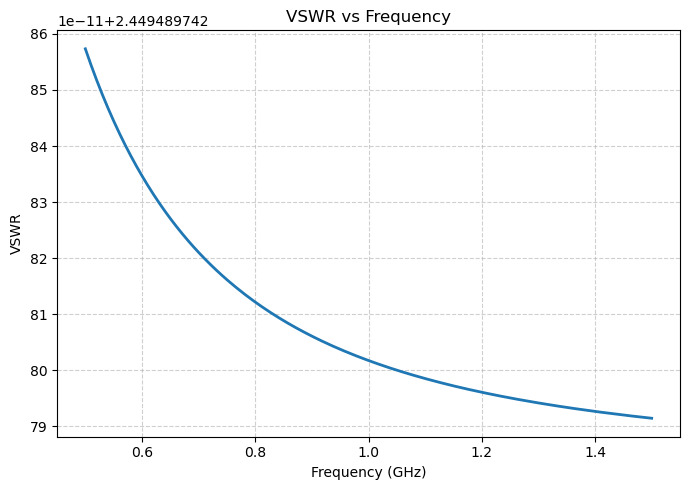

In [23]:
# Sweep frequency and compute VSWR for the same load and per-unit-length params
f_min, f_max = 0.5e9, 1.5e9
freqs = np.linspace(f_min, f_max, 200)
vswr_vals = []
for f in freqs:
    w = 2*np.pi*f
    g, z0 = gamma_Z0(R, L, G, C, w)
    vswr_vals.append(vswr_from_gamma(gamma_of_impedance(ZL, z0)))
vswr_vals = np.array(vswr_vals)

plt.figure(figsize=(7,5))
plt.plot(freqs*1e-9, vswr_vals, linewidth=2)
plt.xlabel("Frequency (GHz)")
plt.ylabel("VSWR")
plt.title("VSWR vs Frequency")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.savefig("figures/vswr_vs_frequency.png", dpi=200)
plt.show()

In [24]:
stub = single_stub_shunt(R, L, G, C, f0, l_total, ZL, prefer='short')
print("Stub match → VSWR at source:", stub.VSWR_src)
print("Optimal stub position d (m):", stub.d_opt)
print("Stub length (m):", stub.l_stub)
print("Notes:", stub.notes)

Stub match → VSWR at source: 2.956837059805464
Optimal stub position d (m): 0.08357034574560561
Stub length (m): (0.026770173003326514+0j)
Notes: Placed at d=0.0836, Yin=0.01631+0.01511j, B_needed=-0.01511, l_stub=0.0268+0.0000j


In [25]:
qwt = quarter_wave_transform(R, L, G, C, f0, ZL)  # Zt auto-chosen ~ sqrt(Re(Z0)
print("QWT match → VSWR at source:", qwt.VSWR_src)
print("Quarter-wave length (m):", qwt.l_qw)
print("Transformer Zt (Ω):", qwt.Zt)

QWT match → VSWR at source: 1.0000000000000002
Quarter-wave length (m): 0.0510310363035013
Transformer Zt (Ω): (39.127114504414465-0.00025927513440287365j)


In [26]:
import joblib
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
import sys, pathlib
repo_root = pathlib.Path().resolve()
src_path = repo_root.parent / "src" if (repo_root / "src").exists() == False else repo_root / "src"
if str(src_path) not in sys.path:
    sys.path.insert(0, str(src_path))
try:
    from tl_dataset import make_regression_data
except ImportError:
    from src.tl_dataset import make_regression_data
def default_reg_data(n=3000):
    return make_regression_data(n)
try:
    X, y = make_regression_data(5000)  # Use new dataset utility
except Exception:
    X, y = default_reg_data(5000)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
reg = RandomForestRegressor(n_estimators=1500, max_depth=None, min_samples_split=2, min_samples_leaf=1, n_jobs=-1, random_state=42)
reg.fit(X_train, y_train)
pred = reg.predict(X_test)
r2 = r2_score(y_test, pred)
mse = mean_squared_error(y_test, pred)
rmse = np.sqrt(mse)
print(f"Regression R^2: {r2:.4f}, RMSE: {rmse:.4f}")
joblib.dump(reg, "models/reg_rf.pkl")

Regression R^2: 0.9903, RMSE: 0.1419


['models/reg_rf.pkl']

In [27]:
import joblib
from sklearn.utils import resample
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier

VSWR_THRESHOLD = 2.0  # pass if VSWR <= 2

def default_cls_data(n=15000):
    rng = np.random.default_rng(7)
    Rv = rng.uniform(0.01, 0.2, n)
    Lv = rng.uniform(1e-7, 5e-7, n)
    Gv = rng.uniform(0, 5e-8, n)
    Cv = rng.uniform(5e-11, 1.2e-10, n)
    fv = rng.uniform(5e8, 1.5e9, n)
    lv = rng.uniform(0.05, 0.5, n)
    RL = rng.uniform(5, 200, n)
    X = np.stack([Rv, Lv, Gv, Cv, fv, lv, RL], axis=1)
    y = []
    for i in range(n):
        g, z0 = gamma_Z0(Rv[i], Lv[i], Gv[i], Cv[i], 2*np.pi*fv[i])
        Gam = gamma_of_impedance(RL[i] + 0j, z0)
        vswr = vswr_from_gamma(Gam)
        y.append(1 if vswr <= VSWR_THRESHOLD else 0)
    return X, np.array(y, dtype=int)

try:
    Xc, yc = make_classification_data(25000)  # type: ignore
except Exception:
    Xc, yc = default_cls_data(25000)

# Balance classes
n_min = min((yc==0).sum(), (yc==1).sum())
Xb = np.vstack([resample(Xc[yc==0], n_samples=n_min, random_state=42),
                resample(Xc[yc==1], n_samples=n_min, random_state=42)])
yb = np.hstack([np.zeros(n_min, dtype=int), np.ones(n_min, dtype=int)])

X_train, X_test, y_train, y_test = train_test_split(Xb, yb, test_size=0.2, random_state=42, stratify=yb)

clf = RandomForestClassifier(
    n_estimators=2000, max_depth=None, min_samples_split=2, min_samples_leaf=1,
    max_features='sqrt', n_jobs=-1, random_state=42
)
clf.fit(X_train, y_train)
yp = clf.predict(X_test)
ypb = clf.predict_proba(X_test)[:,1]
acc = accuracy_score(y_test, yp)
auc = roc_auc_score(y_test, ypb)
print(f"Classification accuracy (RF): {acc:.4f}, ROC AUC: {auc:.4f}")
joblib.dump(clf, "models/cls_rf.pkl")

Classification accuracy (RF): 0.9741, ROC AUC: 0.9985


['models/cls_rf.pkl']